# Outline

* [Setup](#setup)
* [MyNN](#mynn)
* [Pytorch](#pytorch)
* [Keras](#keras)
* [Tensforflow](#tensorflow)

# Setup <a class='anchor' id='setup'></a>

https://www.coursera.org/learn/neural-networks-deep-learning?specialization=deep-learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def load_catvnoncat_data():
    import h5py
    train_dataset = h5py.File('data/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('data/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_catvnoncat_data()

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


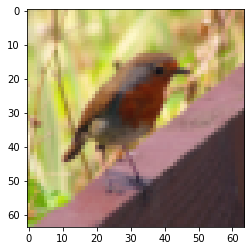

y = 0. It's a non-cat picture.


In [3]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
plt.show()
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

# MyNN <a class='anchor' id='mynn'></a>

In [4]:
from network import NN

## Cat vs. not Cat example

In [5]:
%%time

net = NN([20, 7, 5, 1], [NN.RELU, NN.RELU, NN.RELU, NN.SIGMOID], loss_func=NN.LOGLOSS)
# net.train(train_x, train_y, alpha=0.0075, max_iterations=2400)
trainer = net.train(train_x, train_y, alpha=0.0075, max_iterations=2000, lambd=0.1, return_cost_every=500)
# net.train(train_x, train_y, alpha=0.0075, max_iterations=2400, dropout=[False, 0.01, False, False, False])

for cost in trainer:
    print('cost: {:.2f}'.format(cost.item()))
    pred_y = net.predict(train_x)
    print('Train accuracy: {:.2f}'.format(np.sum(pred_y == train_y)/train_y.shape[1]))
    pred_y = net.predict(test_x)
    print('Test accuracy: {:.2f}'.format(np.sum(pred_y == test_y)/test_y.shape[1]))

cost: 0.78
Train accuracy: 0.52
Test accuracy: 0.42
cost: 0.53
Train accuracy: 0.85
Test accuracy: 0.84
cost: 0.29
Train accuracy: 0.96
Test accuracy: 0.82
cost: 0.15
Train accuracy: 1.00
Test accuracy: 0.78
cost: 0.10
Train accuracy: 1.00
Test accuracy: 0.78
Wall time: 50.2 s


# Pytorch <a class='anchor' id='pytorch'></a>

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

ModuleNotFoundError: No module named 'torch'

## Cat vs. not Cat example

In [ ]:
class DataCatvsnonCat(Dataset):
    def __init__(self, test=False):
        train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_catvnoncat_data()
        
        # Reshape the training and test examples 
        train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)
        test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

        # Standardize data to have feature values between 0 and 1.
        train_x = train_x_flatten/255.
        train_y = train_set_y_orig.T
        test_x = test_x_flatten/255.
        test_y = test_set_y_orig.T
        if not test:
            self.x = train_x
            self.y = train_y
        else:
            self.x = test_x
            self.y = test_y
        self.x = torch.Tensor(self.x)
        self.y = torch.Tensor(self.y)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.y)

In [ ]:
train_data = DataCatvsnonCat()
test_data = DataCatvsnonCat(test=True)

In [ ]:
class TorchNet(torch.nn.Module):
    
    functions = {'relu': torch.relu, 'sigmoid': torch.sigmoid}
    
    def __init__(self, D_in, layers):
        super().__init__()
        assert (len([fstr for _, fstr in layers if fstr not in self.functions]) == 0), 'invalid activation function'        
        self.linears = torch.nn.ModuleList() # this way all linears are registered and parameters are assigned
        self.activations = []
        for D_out, fstr in layers:            
            self.linears.append(torch.nn.Linear(D_in, D_out))
            self.activations.append(self.functions[fstr])
            D_in = D_out        
        
    def forward(self, x):        
        for activation, linear in zip(self.activations, self.linears):
            x = activation(linear(x))
        return x
    
    def __repr__(self):
        return str(list(zip(self.linears, [f.__name__ for f  in self.activations])))

In [ ]:
tnet1 = TorchNet(12288, [(20, 'relu'), (7, 'relu'), (5, 'relu'), (1, 'sigmoid')])
tnet2 = torch.nn.Sequential(torch.nn.Linear(12288, 20), torch.nn.ReLU(),
                            torch.nn.Linear(20, 7), torch.nn.ReLU(), 
                            torch.nn.Linear(7, 5), torch.nn.ReLU(), 
                            torch.nn.Linear(5, 1), torch.nn.Sigmoid())

print('tnet1:\n', tnet1)
print()
print('tnet2:\n', tnet2)

In [ ]:
def train(data_set, model, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        for x, y in data_set:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
%%time
optimizer = torch.optim.Adam(tnet1.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()
train(train_data, tnet1, criterion, optimizer, epochs=2000)

In [ ]:
int((tnet1(test_data[:][0]).round() == test_data[:][1]).sum()) / len(test_data)

In [ ]:
%%time
optimizer = torch.optim.Adam(tnet2.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()
train(train_data, tnet1, criterion, optimizer, epochs=2000)

In [ ]:
int((tnet2(test_data[:][0]).round() == test_data[:][1]).sum()) / len(test_data)

# Keras <a class='anchor' id='keras'></a>

In [7]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Cat vs. not Cat example

In [8]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_catvnoncat_data()

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
train_y = train_y.T
test_y = test_y.T
assert( train_x.shape[0] == train_y.shape[0] and test_x.shape[0] == test_y.shape[0])

print ("train_x's shape: ", train_x.shape)
print ("test_x's shape: ", test_x.shape)

train_x's shape:  (209, 12288)
test_x's shape:  (50, 12288)


In [9]:
num_pixels = train_x.shape[1]

model = Sequential()

# [20, 7, 5, 1]
model.add(Dense(20, activation='relu', input_shape=(num_pixels, )))
model.add(Dense(7, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics='accuracy')

In [10]:
%%time
model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=1000, verbose=2)

Epoch 1/1000
7/7 - 0s - loss: 0.6700 - accuracy: 0.6555 - val_loss: 0.9763 - val_accuracy: 0.3400
Epoch 2/1000
7/7 - 0s - loss: 0.6543 - accuracy: 0.6555 - val_loss: 0.8883 - val_accuracy: 0.3400
Epoch 3/1000
7/7 - 0s - loss: 0.6418 - accuracy: 0.6555 - val_loss: 0.8402 - val_accuracy: 0.3400
Epoch 4/1000
7/7 - 0s - loss: 0.6370 - accuracy: 0.6555 - val_loss: 0.7931 - val_accuracy: 0.3400
Epoch 5/1000
7/7 - 0s - loss: 0.6237 - accuracy: 0.6555 - val_loss: 0.8535 - val_accuracy: 0.3400
Epoch 6/1000
7/7 - 0s - loss: 0.5939 - accuracy: 0.6555 - val_loss: 1.1806 - val_accuracy: 0.3400
Epoch 7/1000
7/7 - 0s - loss: 0.5851 - accuracy: 0.6555 - val_loss: 0.9466 - val_accuracy: 0.3400
Epoch 8/1000
7/7 - 0s - loss: 0.5516 - accuracy: 0.6555 - val_loss: 1.3492 - val_accuracy: 0.3400
Epoch 9/1000
7/7 - 0s - loss: 0.5586 - accuracy: 0.6555 - val_loss: 0.9359 - val_accuracy: 0.3400
Epoch 10/1000
7/7 - 0s - loss: 0.5145 - accuracy: 0.6555 - val_loss: 0.8329 - val_accuracy: 0.3400
Epoch 11/1000
7/7 -

Epoch 84/1000
7/7 - 0s - loss: 0.0841 - accuracy: 0.9856 - val_loss: 1.8027 - val_accuracy: 0.6000
Epoch 85/1000
7/7 - 0s - loss: 0.0550 - accuracy: 0.9952 - val_loss: 1.3134 - val_accuracy: 0.6600
Epoch 86/1000
7/7 - 0s - loss: 0.0558 - accuracy: 0.9904 - val_loss: 1.5310 - val_accuracy: 0.6200
Epoch 87/1000
7/7 - 0s - loss: 0.0619 - accuracy: 0.9856 - val_loss: 2.0710 - val_accuracy: 0.5600
Epoch 88/1000
7/7 - 0s - loss: 0.0550 - accuracy: 0.9856 - val_loss: 1.2353 - val_accuracy: 0.6800
Epoch 89/1000
7/7 - 0s - loss: 0.0583 - accuracy: 0.9904 - val_loss: 1.6122 - val_accuracy: 0.6400
Epoch 90/1000
7/7 - 0s - loss: 0.0404 - accuracy: 0.9952 - val_loss: 1.3954 - val_accuracy: 0.6600
Epoch 91/1000
7/7 - 0s - loss: 0.0407 - accuracy: 0.9904 - val_loss: 1.6336 - val_accuracy: 0.6400
Epoch 92/1000
7/7 - 0s - loss: 0.0363 - accuracy: 0.9952 - val_loss: 1.2592 - val_accuracy: 0.6600
Epoch 93/1000
7/7 - 0s - loss: 0.0391 - accuracy: 0.9904 - val_loss: 1.9771 - val_accuracy: 0.6000
Epoch 94/1

7/7 - 0s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.8934 - val_accuracy: 0.6800
Epoch 167/1000
7/7 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.9502 - val_accuracy: 0.6600
Epoch 168/1000
7/7 - 0s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 1.9306 - val_accuracy: 0.6800
Epoch 169/1000
7/7 - 0s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 2.0119 - val_accuracy: 0.6400
Epoch 170/1000
7/7 - 0s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.8979 - val_accuracy: 0.7000
Epoch 171/1000
7/7 - 0s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 2.0309 - val_accuracy: 0.6400
Epoch 172/1000
7/7 - 0s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.9173 - val_accuracy: 0.6800
Epoch 173/1000
7/7 - 0s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 2.0368 - val_accuracy: 0.6400
Epoch 174/1000
7/7 - 0s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.9508 - val_accuracy: 0.7000
Epoch 175/1000
7/7 - 0s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 2.0444 - val_accuracy: 0.6400
Epoch 176/1000


Epoch 249/1000
7/7 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.2508 - val_accuracy: 0.6800
Epoch 250/1000
7/7 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.2611 - val_accuracy: 0.6800
Epoch 251/1000
7/7 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.2702 - val_accuracy: 0.6800
Epoch 252/1000
7/7 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.2838 - val_accuracy: 0.6800
Epoch 253/1000
7/7 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.2652 - val_accuracy: 0.6800
Epoch 254/1000
7/7 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.2854 - val_accuracy: 0.6800
Epoch 255/1000
7/7 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.3092 - val_accuracy: 0.6600
Epoch 256/1000
7/7 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.2755 - val_accuracy: 0.6800
Epoch 257/1000
7/7 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.2909 - val_accuracy: 0.6800
Epoch 258/1000
7/7 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.3133 - val_accuracy: 0.6600


Epoch 331/1000
7/7 - 0s - loss: 8.9484e-04 - accuracy: 1.0000 - val_loss: 2.5165 - val_accuracy: 0.6600
Epoch 332/1000
7/7 - 0s - loss: 8.7698e-04 - accuracy: 1.0000 - val_loss: 2.4929 - val_accuracy: 0.6800
Epoch 333/1000
7/7 - 0s - loss: 8.7944e-04 - accuracy: 1.0000 - val_loss: 2.5226 - val_accuracy: 0.6600
Epoch 334/1000
7/7 - 0s - loss: 8.6924e-04 - accuracy: 1.0000 - val_loss: 2.5069 - val_accuracy: 0.7000
Epoch 335/1000
7/7 - 0s - loss: 8.6162e-04 - accuracy: 1.0000 - val_loss: 2.5243 - val_accuracy: 0.6600
Epoch 336/1000
7/7 - 0s - loss: 8.5434e-04 - accuracy: 1.0000 - val_loss: 2.5160 - val_accuracy: 0.6600
Epoch 337/1000
7/7 - 0s - loss: 8.4925e-04 - accuracy: 1.0000 - val_loss: 2.5247 - val_accuracy: 0.6600
Epoch 338/1000
7/7 - 0s - loss: 8.4281e-04 - accuracy: 1.0000 - val_loss: 2.5493 - val_accuracy: 0.6600
Epoch 339/1000
7/7 - 0s - loss: 8.4283e-04 - accuracy: 1.0000 - val_loss: 2.5249 - val_accuracy: 0.6600
Epoch 340/1000
7/7 - 0s - loss: 8.3605e-04 - accuracy: 1.0000 - 

Epoch 410/1000
7/7 - 0s - loss: 5.1999e-04 - accuracy: 1.0000 - val_loss: 2.7107 - val_accuracy: 0.6800
Epoch 411/1000
7/7 - 0s - loss: 5.3564e-04 - accuracy: 1.0000 - val_loss: 2.7805 - val_accuracy: 0.6400
Epoch 412/1000
7/7 - 0s - loss: 5.0226e-04 - accuracy: 1.0000 - val_loss: 2.6566 - val_accuracy: 0.7000
Epoch 413/1000
7/7 - 0s - loss: 5.1919e-04 - accuracy: 1.0000 - val_loss: 2.7385 - val_accuracy: 0.6800
Epoch 414/1000
7/7 - 0s - loss: 4.9529e-04 - accuracy: 1.0000 - val_loss: 2.7591 - val_accuracy: 0.6600
Epoch 415/1000
7/7 - 0s - loss: 4.8647e-04 - accuracy: 1.0000 - val_loss: 2.7195 - val_accuracy: 0.6800
Epoch 416/1000
7/7 - 0s - loss: 4.9151e-04 - accuracy: 1.0000 - val_loss: 2.7166 - val_accuracy: 0.6600
Epoch 417/1000
7/7 - 0s - loss: 4.8007e-04 - accuracy: 1.0000 - val_loss: 2.7436 - val_accuracy: 0.6600
Epoch 418/1000
7/7 - 0s - loss: 4.8079e-04 - accuracy: 1.0000 - val_loss: 2.7340 - val_accuracy: 0.6600
Epoch 419/1000
7/7 - 0s - loss: 4.7253e-04 - accuracy: 1.0000 - 

Epoch 489/1000
7/7 - 0s - loss: 3.0350e-04 - accuracy: 1.0000 - val_loss: 2.9134 - val_accuracy: 0.6600
Epoch 490/1000
7/7 - 0s - loss: 3.0477e-04 - accuracy: 1.0000 - val_loss: 2.8810 - val_accuracy: 0.6600
Epoch 491/1000
7/7 - 0s - loss: 2.9980e-04 - accuracy: 1.0000 - val_loss: 2.9009 - val_accuracy: 0.6600
Epoch 492/1000
7/7 - 0s - loss: 2.9928e-04 - accuracy: 1.0000 - val_loss: 2.8998 - val_accuracy: 0.6800
Epoch 493/1000
7/7 - 0s - loss: 2.9833e-04 - accuracy: 1.0000 - val_loss: 2.9171 - val_accuracy: 0.6800
Epoch 494/1000
7/7 - 0s - loss: 2.9476e-04 - accuracy: 1.0000 - val_loss: 2.9029 - val_accuracy: 0.6600
Epoch 495/1000
7/7 - 0s - loss: 2.9301e-04 - accuracy: 1.0000 - val_loss: 2.9000 - val_accuracy: 0.6600
Epoch 496/1000
7/7 - 0s - loss: 2.9644e-04 - accuracy: 1.0000 - val_loss: 2.8902 - val_accuracy: 0.6600
Epoch 497/1000
7/7 - 0s - loss: 3.0228e-04 - accuracy: 1.0000 - val_loss: 2.9383 - val_accuracy: 0.6600
Epoch 498/1000
7/7 - 0s - loss: 2.8578e-04 - accuracy: 1.0000 - 

Epoch 568/1000
7/7 - 0s - loss: 1.9994e-04 - accuracy: 1.0000 - val_loss: 3.0773 - val_accuracy: 0.6600
Epoch 569/1000
7/7 - 0s - loss: 1.9613e-04 - accuracy: 1.0000 - val_loss: 3.0096 - val_accuracy: 0.6800
Epoch 570/1000
7/7 - 0s - loss: 1.9411e-04 - accuracy: 1.0000 - val_loss: 3.0526 - val_accuracy: 0.6800
Epoch 571/1000
7/7 - 0s - loss: 1.9037e-04 - accuracy: 1.0000 - val_loss: 3.0787 - val_accuracy: 0.6600
Epoch 572/1000
7/7 - 0s - loss: 1.8941e-04 - accuracy: 1.0000 - val_loss: 3.0461 - val_accuracy: 0.6800
Epoch 573/1000
7/7 - 0s - loss: 1.8878e-04 - accuracy: 1.0000 - val_loss: 3.0473 - val_accuracy: 0.6600
Epoch 574/1000
7/7 - 0s - loss: 1.8684e-04 - accuracy: 1.0000 - val_loss: 3.0694 - val_accuracy: 0.6600
Epoch 575/1000
7/7 - 0s - loss: 1.8720e-04 - accuracy: 1.0000 - val_loss: 3.0738 - val_accuracy: 0.6600
Epoch 576/1000
7/7 - 0s - loss: 1.8544e-04 - accuracy: 1.0000 - val_loss: 3.0508 - val_accuracy: 0.6600
Epoch 577/1000
7/7 - 0s - loss: 1.8392e-04 - accuracy: 1.0000 - 

Epoch 647/1000
7/7 - 0s - loss: 1.2726e-04 - accuracy: 1.0000 - val_loss: 3.2029 - val_accuracy: 0.6800
Epoch 648/1000
7/7 - 0s - loss: 1.2646e-04 - accuracy: 1.0000 - val_loss: 3.2131 - val_accuracy: 0.6600
Epoch 649/1000
7/7 - 0s - loss: 1.2552e-04 - accuracy: 1.0000 - val_loss: 3.1975 - val_accuracy: 0.6600
Epoch 650/1000
7/7 - 0s - loss: 1.2488e-04 - accuracy: 1.0000 - val_loss: 3.2039 - val_accuracy: 0.6600
Epoch 651/1000
7/7 - 0s - loss: 1.2504e-04 - accuracy: 1.0000 - val_loss: 3.2255 - val_accuracy: 0.6600
Epoch 652/1000
7/7 - 0s - loss: 1.2540e-04 - accuracy: 1.0000 - val_loss: 3.1935 - val_accuracy: 0.6800
Epoch 653/1000
7/7 - 0s - loss: 1.2267e-04 - accuracy: 1.0000 - val_loss: 3.2225 - val_accuracy: 0.6800
Epoch 654/1000
7/7 - 0s - loss: 1.2269e-04 - accuracy: 1.0000 - val_loss: 3.2190 - val_accuracy: 0.6800
Epoch 655/1000
7/7 - 0s - loss: 1.2187e-04 - accuracy: 1.0000 - val_loss: 3.2197 - val_accuracy: 0.6800
Epoch 656/1000
7/7 - 0s - loss: 1.2372e-04 - accuracy: 1.0000 - 

Epoch 726/1000
7/7 - 0s - loss: 8.4837e-05 - accuracy: 1.0000 - val_loss: 3.3014 - val_accuracy: 0.6800
Epoch 727/1000
7/7 - 0s - loss: 8.6387e-05 - accuracy: 1.0000 - val_loss: 3.3439 - val_accuracy: 0.6800
Epoch 728/1000
7/7 - 0s - loss: 8.4131e-05 - accuracy: 1.0000 - val_loss: 3.3449 - val_accuracy: 0.6800
Epoch 729/1000
7/7 - 0s - loss: 8.3884e-05 - accuracy: 1.0000 - val_loss: 3.3410 - val_accuracy: 0.6800
Epoch 730/1000
7/7 - 0s - loss: 8.4193e-05 - accuracy: 1.0000 - val_loss: 3.3336 - val_accuracy: 0.6800
Epoch 731/1000
7/7 - 0s - loss: 8.2677e-05 - accuracy: 1.0000 - val_loss: 3.3586 - val_accuracy: 0.6800
Epoch 732/1000
7/7 - 0s - loss: 8.3718e-05 - accuracy: 1.0000 - val_loss: 3.3708 - val_accuracy: 0.6800
Epoch 733/1000
7/7 - 0s - loss: 8.2482e-05 - accuracy: 1.0000 - val_loss: 3.3226 - val_accuracy: 0.6800
Epoch 734/1000
7/7 - 0s - loss: 8.2580e-05 - accuracy: 1.0000 - val_loss: 3.3570 - val_accuracy: 0.6800
Epoch 735/1000
7/7 - 0s - loss: 8.1805e-05 - accuracy: 1.0000 - 

Epoch 805/1000
7/7 - 0s - loss: 5.8229e-05 - accuracy: 1.0000 - val_loss: 3.4702 - val_accuracy: 0.6800
Epoch 806/1000
7/7 - 0s - loss: 5.7934e-05 - accuracy: 1.0000 - val_loss: 3.4834 - val_accuracy: 0.6800
Epoch 807/1000
7/7 - 0s - loss: 5.7680e-05 - accuracy: 1.0000 - val_loss: 3.4721 - val_accuracy: 0.6800
Epoch 808/1000
7/7 - 0s - loss: 5.7501e-05 - accuracy: 1.0000 - val_loss: 3.4724 - val_accuracy: 0.6800
Epoch 809/1000
7/7 - 0s - loss: 5.7131e-05 - accuracy: 1.0000 - val_loss: 3.5046 - val_accuracy: 0.6800
Epoch 810/1000
7/7 - 0s - loss: 5.7272e-05 - accuracy: 1.0000 - val_loss: 3.4780 - val_accuracy: 0.6800
Epoch 811/1000
7/7 - 0s - loss: 5.6645e-05 - accuracy: 1.0000 - val_loss: 3.4828 - val_accuracy: 0.6800
Epoch 812/1000
7/7 - 0s - loss: 5.6703e-05 - accuracy: 1.0000 - val_loss: 3.5005 - val_accuracy: 0.6600
Epoch 813/1000
7/7 - 0s - loss: 5.6433e-05 - accuracy: 1.0000 - val_loss: 3.4663 - val_accuracy: 0.6800
Epoch 814/1000
7/7 - 0s - loss: 5.5865e-05 - accuracy: 1.0000 - 

Epoch 884/1000
7/7 - 0s - loss: 4.0249e-05 - accuracy: 1.0000 - val_loss: 3.6116 - val_accuracy: 0.6800
Epoch 885/1000
7/7 - 0s - loss: 4.0083e-05 - accuracy: 1.0000 - val_loss: 3.6188 - val_accuracy: 0.6800
Epoch 886/1000
7/7 - 0s - loss: 3.9872e-05 - accuracy: 1.0000 - val_loss: 3.6111 - val_accuracy: 0.6800
Epoch 887/1000
7/7 - 0s - loss: 3.9661e-05 - accuracy: 1.0000 - val_loss: 3.6086 - val_accuracy: 0.6800
Epoch 888/1000
7/7 - 0s - loss: 3.9382e-05 - accuracy: 1.0000 - val_loss: 3.6169 - val_accuracy: 0.6800
Epoch 889/1000
7/7 - 0s - loss: 3.9343e-05 - accuracy: 1.0000 - val_loss: 3.6169 - val_accuracy: 0.6800
Epoch 890/1000
7/7 - 0s - loss: 3.9637e-05 - accuracy: 1.0000 - val_loss: 3.6337 - val_accuracy: 0.6600
Epoch 891/1000
7/7 - 0s - loss: 3.9612e-05 - accuracy: 1.0000 - val_loss: 3.5929 - val_accuracy: 0.6800
Epoch 892/1000
7/7 - 0s - loss: 3.9185e-05 - accuracy: 1.0000 - val_loss: 3.6479 - val_accuracy: 0.6600
Epoch 893/1000
7/7 - 0s - loss: 3.8721e-05 - accuracy: 1.0000 - 

Epoch 963/1000
7/7 - 0s - loss: 2.8005e-05 - accuracy: 1.0000 - val_loss: 3.7517 - val_accuracy: 0.6800
Epoch 964/1000
7/7 - 0s - loss: 2.8417e-05 - accuracy: 1.0000 - val_loss: 3.7406 - val_accuracy: 0.6800
Epoch 965/1000
7/7 - 0s - loss: 2.7927e-05 - accuracy: 1.0000 - val_loss: 3.7195 - val_accuracy: 0.6800
Epoch 966/1000
7/7 - 0s - loss: 2.7927e-05 - accuracy: 1.0000 - val_loss: 3.7405 - val_accuracy: 0.6800
Epoch 967/1000
7/7 - 0s - loss: 2.7547e-05 - accuracy: 1.0000 - val_loss: 3.7388 - val_accuracy: 0.6800
Epoch 968/1000
7/7 - 0s - loss: 2.7553e-05 - accuracy: 1.0000 - val_loss: 3.7305 - val_accuracy: 0.6800
Epoch 969/1000
7/7 - 0s - loss: 2.7290e-05 - accuracy: 1.0000 - val_loss: 3.7498 - val_accuracy: 0.6800
Epoch 970/1000
7/7 - 0s - loss: 2.7313e-05 - accuracy: 1.0000 - val_loss: 3.7393 - val_accuracy: 0.6800
Epoch 971/1000
7/7 - 0s - loss: 2.7217e-05 - accuracy: 1.0000 - val_loss: 3.7521 - val_accuracy: 0.6800
Epoch 972/1000
7/7 - 0s - loss: 2.6968e-05 - accuracy: 1.0000 - 

In [11]:
model.evaluate(test_x, test_y)

2/2 [==============================] - 0s 2ms/step - loss: 3.7805 - accuracy: 0.6800


[3.780543804168701, 0.6800000071525574]

### using CNN

In [12]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_catvnoncat_data()
# Standardize data to have feature values between 0 and 1.
train_x = train_x_orig/255.
test_x = test_x_orig/255.
train_y = train_y.T
test_y = test_y.T
assert( train_x.shape[0] == train_y.shape[0] and test_x.shape[0] == test_y.shape[0])

print ("train_x's shape: ", train_x.shape)
print ("test_x's shape: ", test_x.shape)

train_x's shape:  (209, 64, 64, 3)
test_x's shape:  (50, 64, 64, 3)


In [13]:
from tensorflow.keras.layers import Conv2D # to add convolutional layers
from tensorflow.keras.layers import MaxPooling2D # to add pooling layers
from tensorflow.keras.layers import Flatten # to flatten data for fully connected layers

In [14]:
# create model
model = Sequential()
model.add(Conv2D(8, (5, 5), strides=(1, 1), padding='valid', activation='relu', input_shape=train_x.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

In [15]:
%%time
model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=10, verbose=2)

Epoch 1/10
21/21 - 1s - loss: 4.1067e-08 - accuracy: 0.3636 - val_loss: 7.8678e-08 - val_accuracy: 0.5800
Epoch 2/10
21/21 - 1s - loss: 4.1067e-08 - accuracy: 0.3636 - val_loss: 7.8678e-08 - val_accuracy: 0.5800
Epoch 3/10
21/21 - 1s - loss: 4.1067e-08 - accuracy: 0.3636 - val_loss: 7.8678e-08 - val_accuracy: 0.5800
Epoch 4/10
21/21 - 1s - loss: 4.1067e-08 - accuracy: 0.3636 - val_loss: 7.8678e-08 - val_accuracy: 0.5800
Epoch 5/10
21/21 - 1s - loss: 4.1067e-08 - accuracy: 0.3636 - val_loss: 7.8678e-08 - val_accuracy: 0.5800
Epoch 6/10
21/21 - 1s - loss: 4.1067e-08 - accuracy: 0.3636 - val_loss: 7.8678e-08 - val_accuracy: 0.5800
Epoch 7/10
21/21 - 1s - loss: 4.1067e-08 - accuracy: 0.3636 - val_loss: 7.8678e-08 - val_accuracy: 0.5800
Epoch 8/10
21/21 - 1s - loss: 4.1067e-08 - accuracy: 0.3636 - val_loss: 7.8678e-08 - val_accuracy: 0.5800
Epoch 9/10
21/21 - 1s - loss: 4.1067e-08 - accuracy: 0.3636 - val_loss: 7.8678e-08 - val_accuracy: 0.5800
Epoch 10/10
21/21 - 1s - loss: 4.1067e-08 - ac

# Tensorflow <a class='anchor' id='tensorflow'></a>

## Cat vs. not Cat example